# Variational Autoencoders
Variational autoencoders (VAE) are a powerful and widely-used class of models to learn complex data distributions in an unsupervised fashion.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/MNIST_data')

Extracting /tmp/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [4]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8#16#

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2
print('49 * {} // 2 = {}'.format(dec_in_channels,inputs_decoder ))

49 * 1 // 2 = 24


###  Defining the encoder
What's most noteworthy is the fact that we are creating two vectors in our encoder, as the encoder is supposed to create objects following a Gaussian Distribution:
* A vector of means
* A vector of standard deviations

You will see later how we "force" the encoder to make sure it really creates values following a Normal Distribution. The returned values that will be fed to the decoder are the z-values. We will need the mean and standard deviation of our distributions later, when computing losses.

In [5]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(x.shape) #(?, 14, 14, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(x.shape) #(?, 7, 7, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        print(x.shape) #(?, 7, 7, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        print(x.shape) #(?, 3136)

        mn = tf.layers.dense(x, units=n_latent) # units: Integer or Long, dimensionality of the output space.
        print(mn.shape) #(?, 8)
        sd = 0.5 * tf.layers.dense(x, units=n_latent) 
        print(sd.shape) #(?, 8)
        
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        print(epsilon.shape) #(?, 8)
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        print(z.shape) #(?, 8)
        return z, mn, sd

In [6]:
print('X_in : ', X_in.shape)
sampled, mn, sd = encoder(X_in, keep_prob)
print(sampled.shape) #(?, 8)
print(sampled)

X_in :  (?, 28, 28)
(?, 14, 14, 64)
(?, 7, 7, 64)
(?, 7, 7, 64)
(?, 3136)
(?, 8)
(?, 8)
(?, 8)
(?, 8)
(?, 8)
Tensor("encoder/add:0", shape=(?, 8), dtype=float32)


### Defining the decoder
The decoder **does not** care about whether the input values are sampled from some specific distribution that has been defined by us. It simply will try to reconstruct the input images. To this end, we use a series of transpose convolutions.

In [7]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        print(x.shape) #(?, 24)
        #x = tf.layers.dense(sampled_z, inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        print(x.shape) #(?, 49)
        x = tf.reshape(x, reshaped_dim)
        print(x.shape) #(?, 7, 7, 1)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        print(x.shape) #(?, 14, 14, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        print(x.shape) #(?, 14, 14, 64)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        print(x.shape) #(?, 14, 14, 64)
        
        x = tf.contrib.layers.flatten(x)
        print(x.shape) #(?, 12544)
        
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        print(x.shape) #(?, 784)
        
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

Now, we'll wire together both parts:

In [8]:
dec = decoder(sampled, keep_prob)

(?, 24)
(?, 49)
(?, 7, 7, 1)
(?, 14, 14, 64)
(?, 14, 14, 64)
(?, 14, 14, 64)
(?, 12544)
(?, 784)


### Computing losses and enforcing a Gaussian latent distribution
For computing the image reconstruction loss, we simply use squared difference (which could lead to images sometimes looking a bit fuzzy). This loss is combined with the Kullback-Leibler divergence, which makes sure our latent values will be sampled from a normal distribution. For more on this topic, please take a look a Jaan Altosaar's great article on VAEs.

In [9]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)


In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Training the network

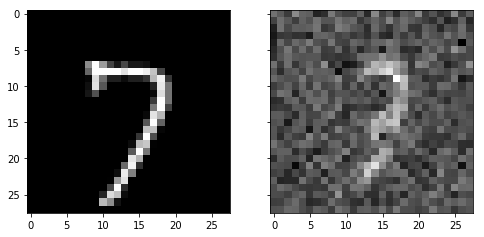

0 177.0364 177.03293 0.0034884755


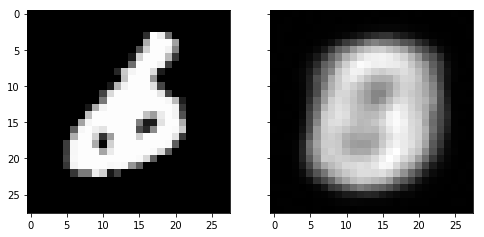

200 50.028866 48.56247 1.4663972


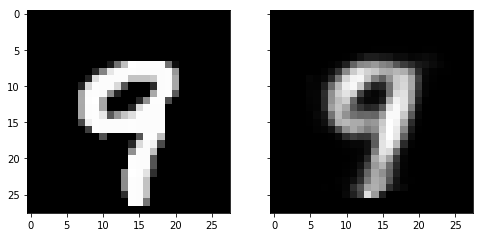

400 41.719437 36.43683 5.282609


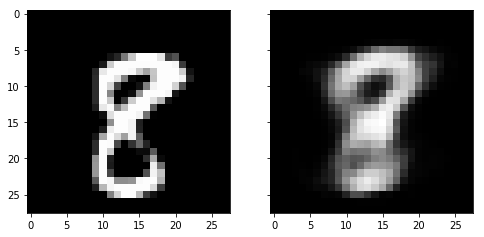

600 36.28173 28.971916 7.309812


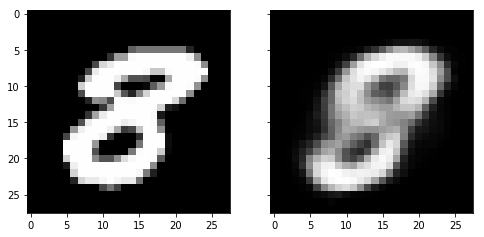

800 34.14378 26.432013 7.7117686


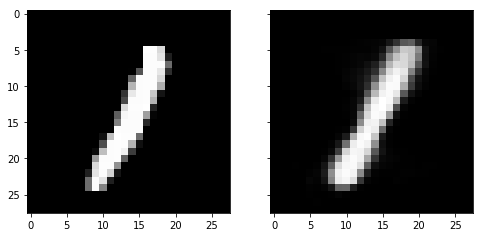

1000 33.477127 25.217413 8.259711


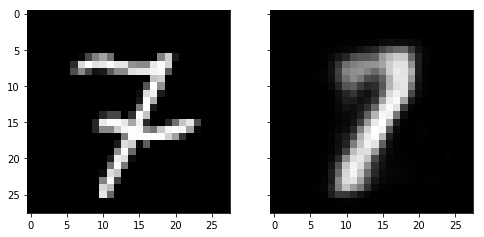

1200 32.84725 24.5224 8.324852


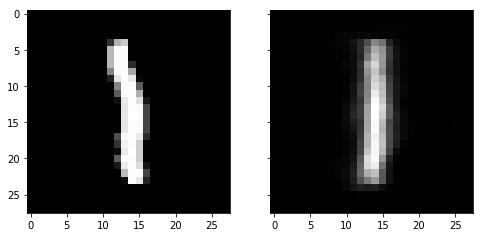

1400 31.844795 22.638752 9.206043


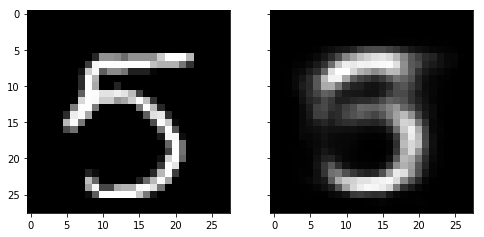

1600 33.86798 25.3796 8.488379


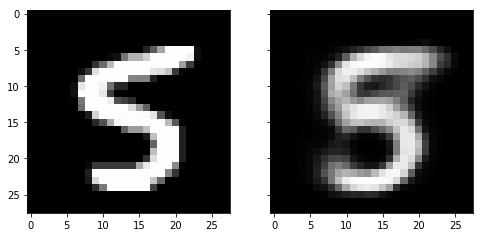

1800 31.31781 22.92507 8.39274


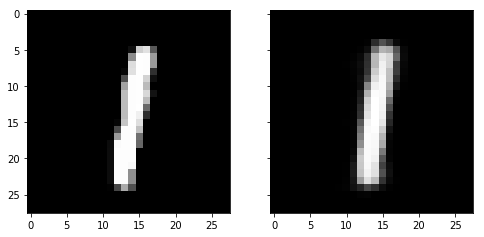

2000 29.748903 20.82585 8.923055


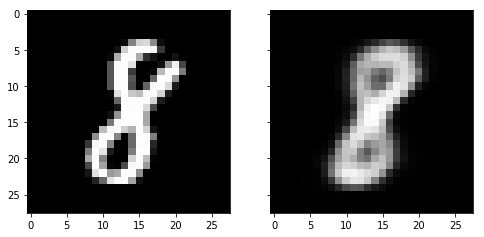

2200 30.654789 21.32632 9.328468


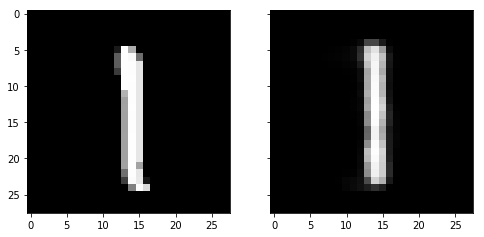

2400 31.555344 21.804855 9.750486


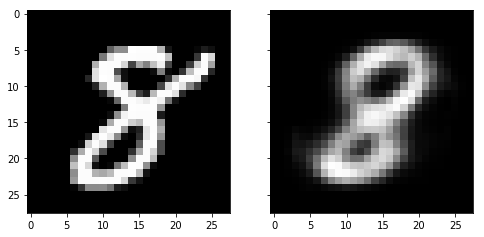

2600 30.996998 21.326439 9.670559


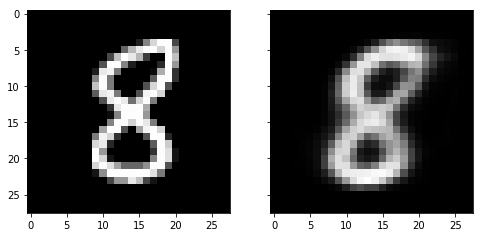

2800 29.134365 20.293127 8.84124


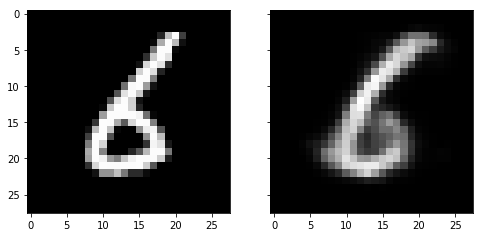

3000 28.587265 18.77955 9.807713


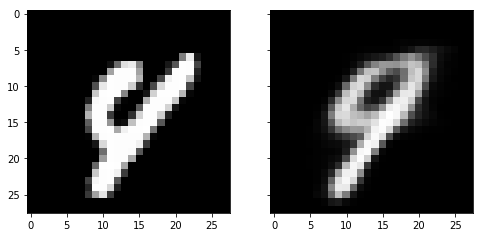

3200 33.24667 23.34396 9.90271


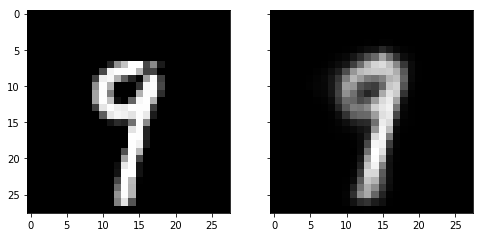

3400 28.92302 19.227737 9.695283


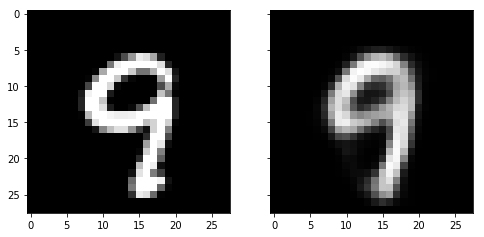

3600 30.643303 21.132658 9.510643


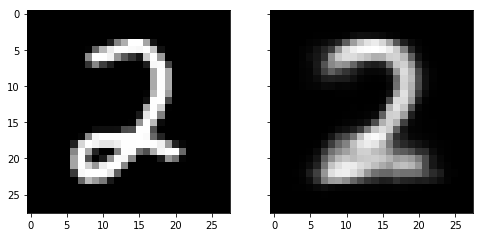

3800 30.000542 20.884394 9.116148


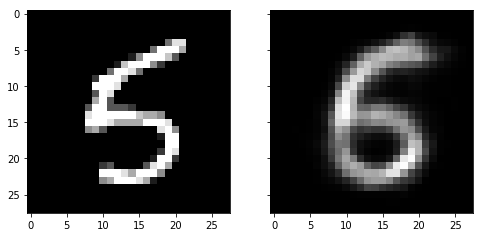

4000 28.516293 19.21275 9.303545


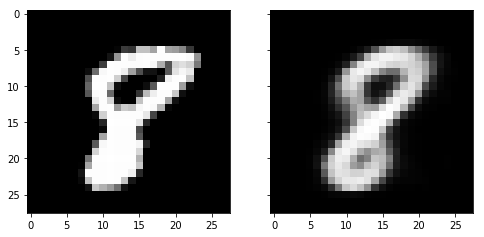

4200 30.207178 20.991295 9.215884


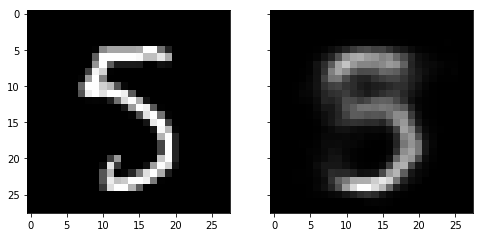

4400 28.208897 18.480255 9.7286415


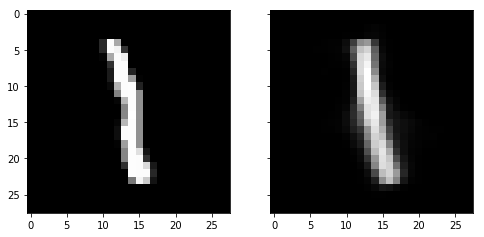

4600 28.950342 19.813005 9.137337


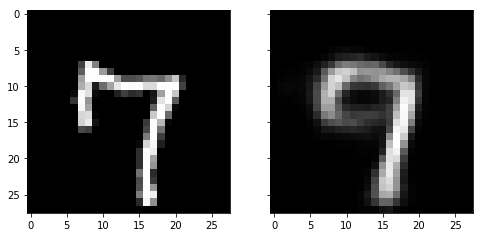

4800 28.138893 18.462357 9.676535


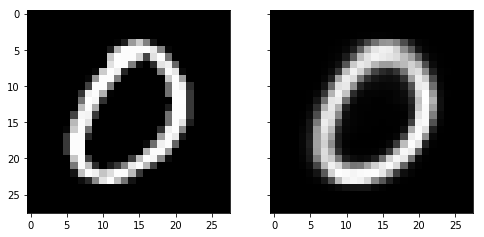

5000 28.8668 19.088104 9.778695


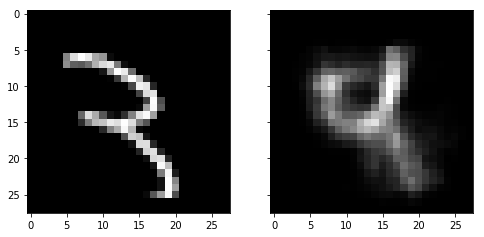

5200 28.171368 19.00174 9.169629


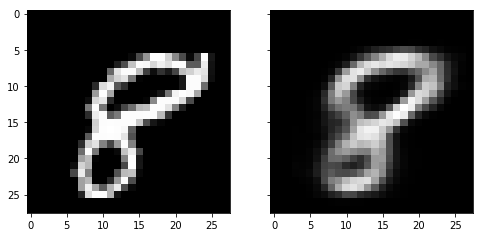

5400 29.951233 19.768091 10.183143


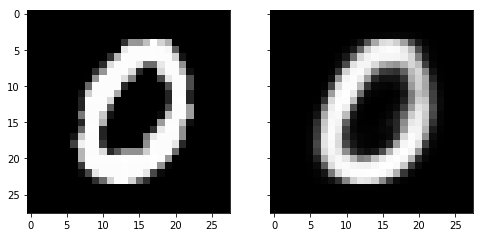

5600 30.427029 20.546509 9.880522


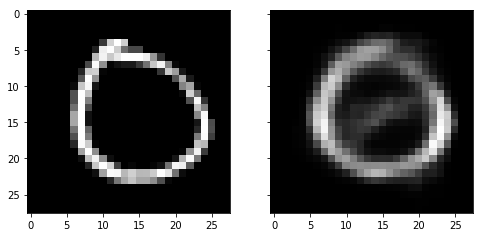

5800 29.434772 19.605412 9.829361


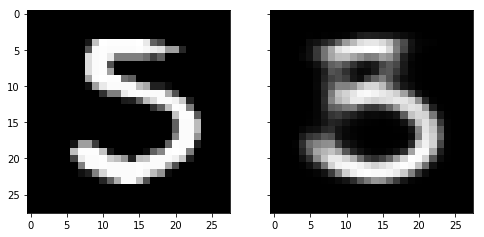

6000 29.809017 19.47993 10.329084


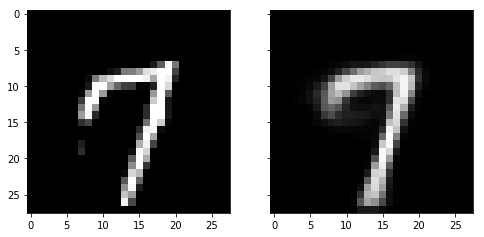

6200 28.592447 18.498695 10.093751


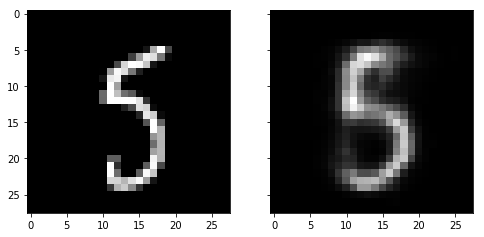

6400 28.943138 19.247726 9.695413


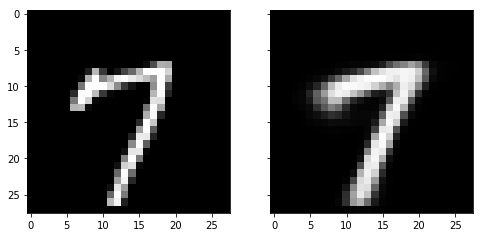

6600 29.502872 19.7057 9.797172


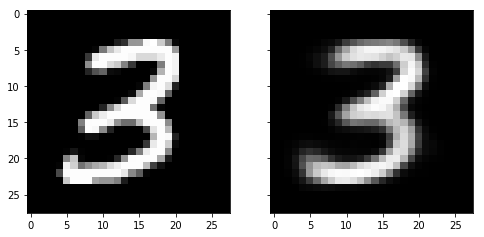

6800 27.819893 18.176931 9.642961


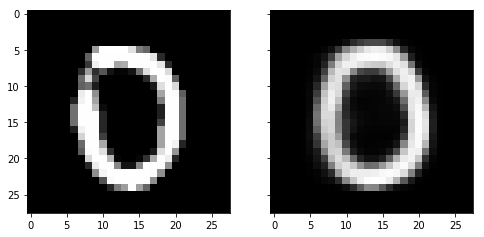

7000 31.5713 21.3822 10.189102


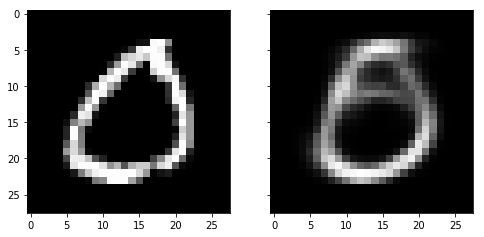

7200 28.881172 18.936901 9.944271


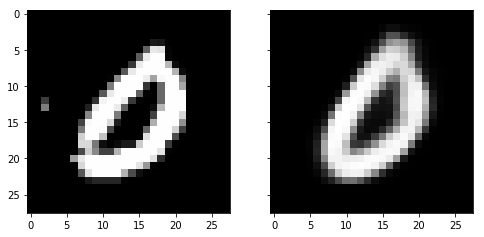

7400 27.981234 18.063663 9.917568


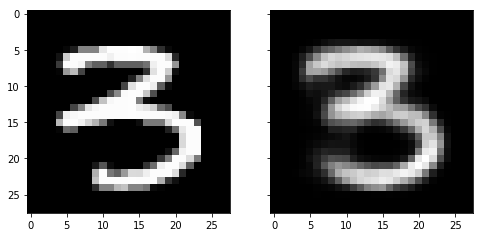

7600 30.607336 20.393797 10.213539


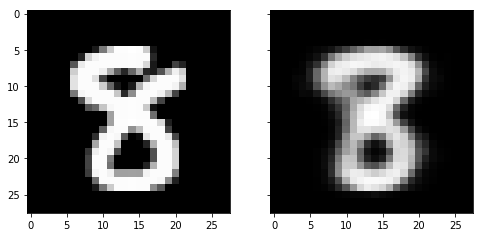

7800 27.50266 17.507376 9.995284


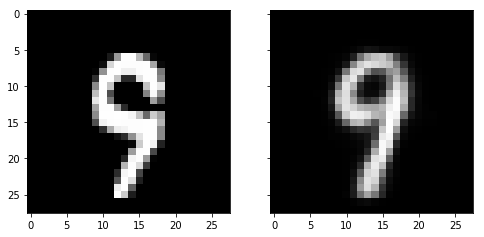

8000 27.03345 17.21252 9.820929


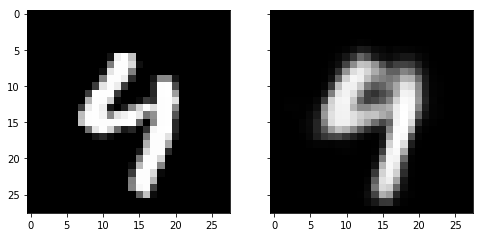

8200 29.36015 18.621754 10.738395


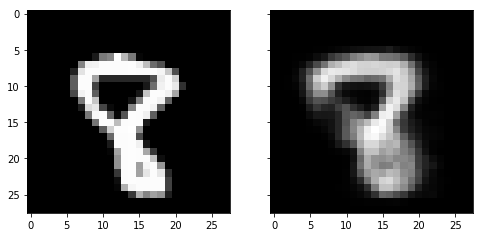

8400 26.904171 16.873293 10.030878


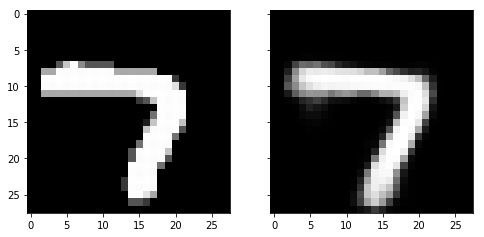

8600 28.277815 17.979195 10.29862


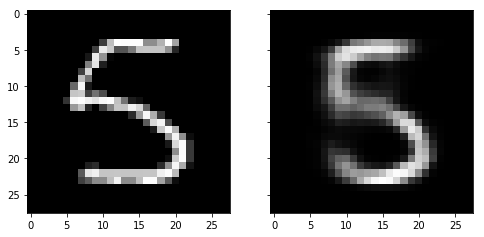

8800 28.721989 18.752176 9.969812


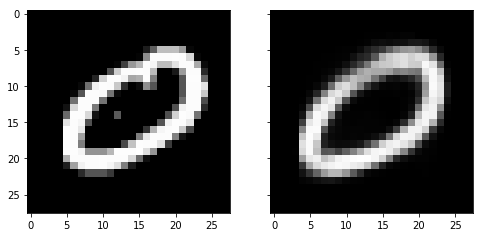

9000 29.678543 19.612114 10.066427


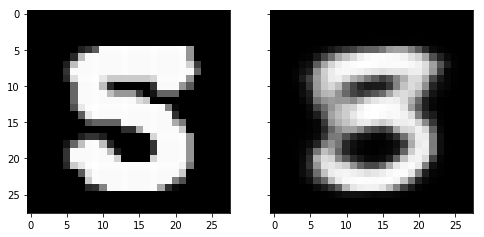

9200 28.737404 18.5373 10.200104


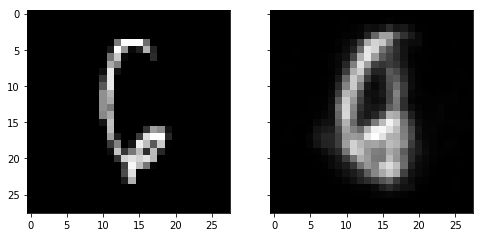

9400 28.911877 18.837688 10.07419


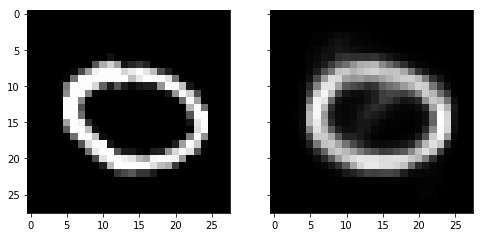

9600 30.392757 20.437756 9.955


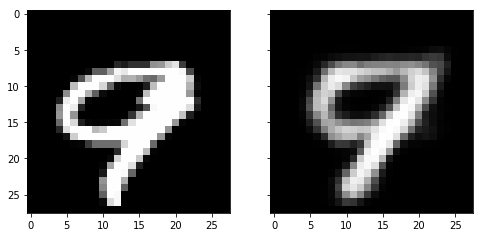

9800 29.700792 18.87733 10.823462


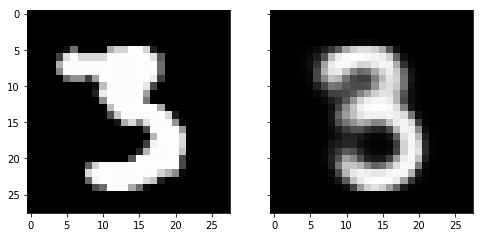

10000 27.747234 17.696135 10.0511


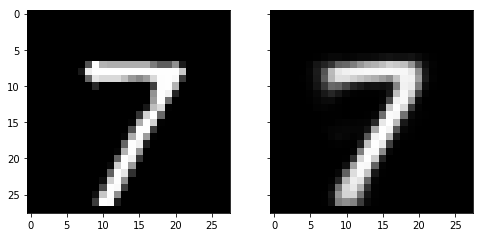

10200 28.918348 18.6381 10.28025


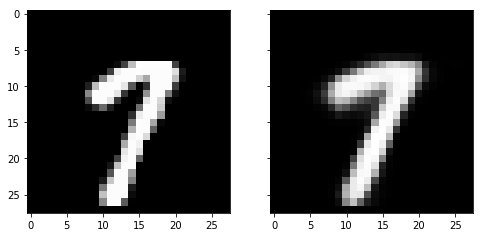

10400 28.546215 18.232275 10.313938


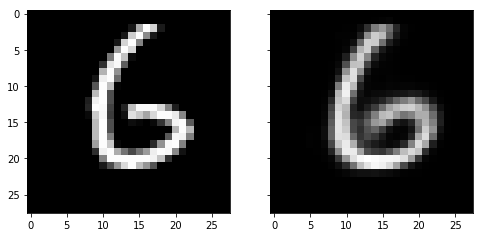

10600 28.42648 18.376492 10.04999


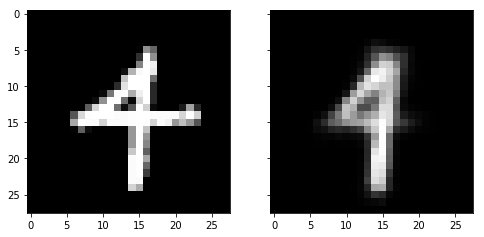

10800 29.002737 19.311779 9.690958


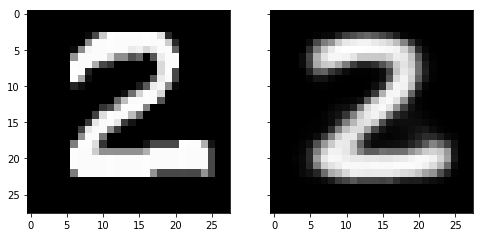

11000 28.861267 18.998613 9.862654


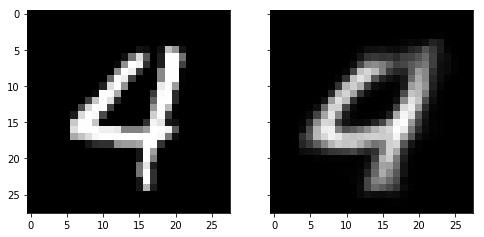

11200 27.865948 17.747608 10.118338


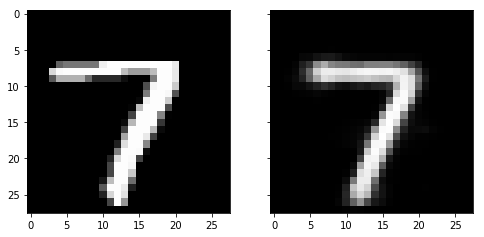

11400 29.511429 19.303055 10.208373


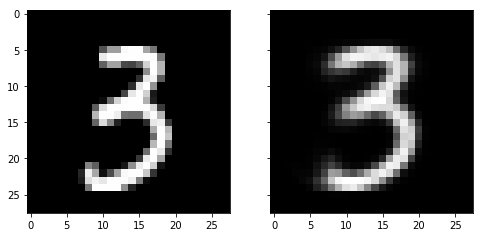

11600 28.427128 18.13159 10.29554


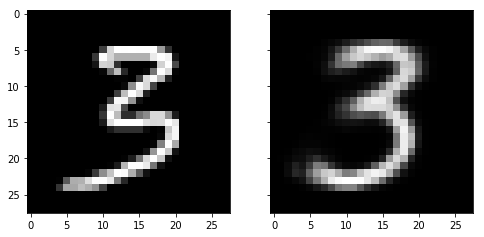

11800 30.298565 19.85482 10.443745


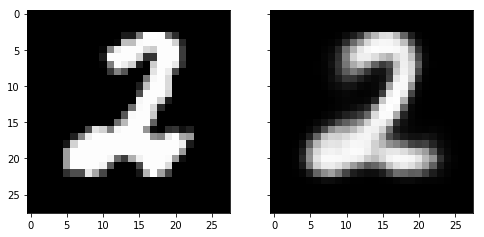

12000 29.388323 18.175999 11.212323


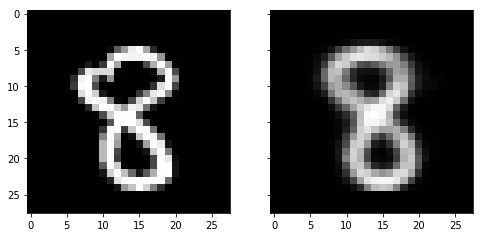

12200 28.028381 17.71545 10.312933


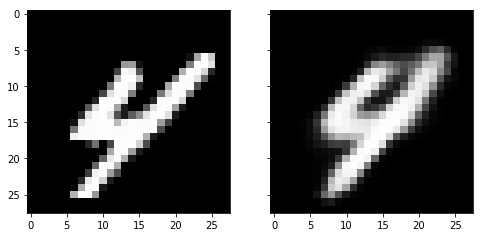

12400 28.801313 18.517193 10.2841215


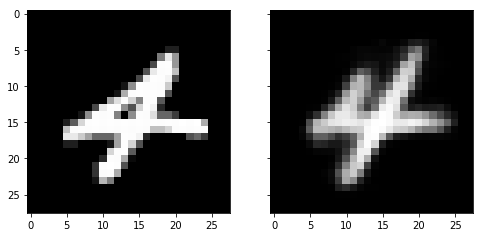

12600 28.454655 18.52209 9.932564


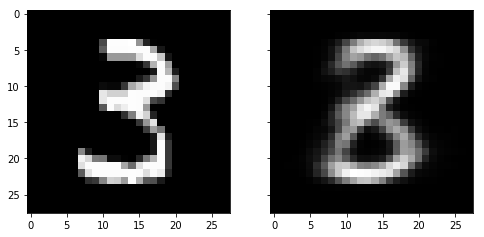

12800 27.045284 16.55681 10.488476


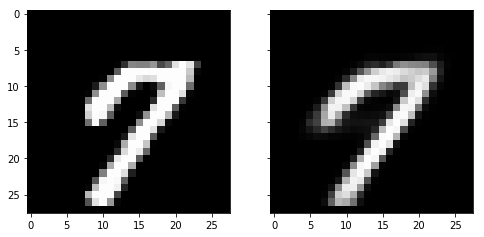

13000 28.460321 17.942467 10.517856


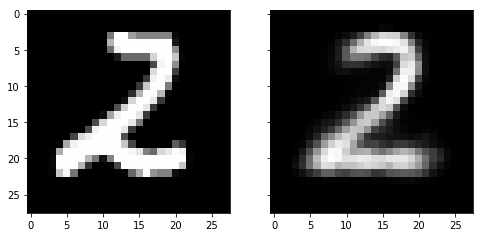

13200 30.856285 20.370607 10.485679


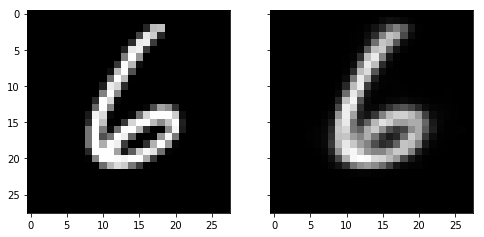

13400 26.73817 16.421291 10.316881


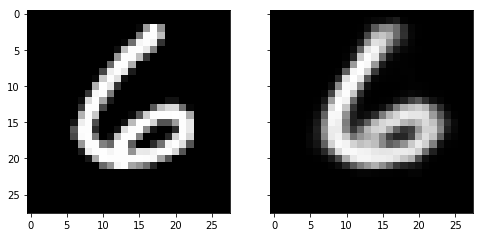

13600 28.57123 17.749348 10.821882


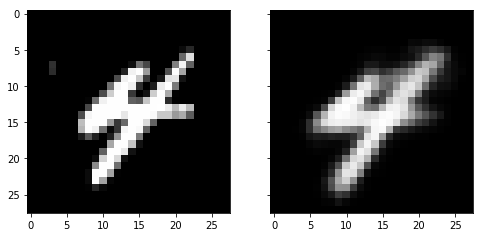

13800 26.11446 15.779808 10.334652


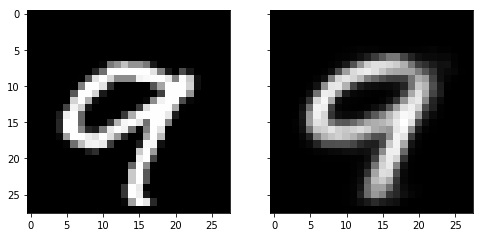

14000 27.336483 17.205074 10.131407


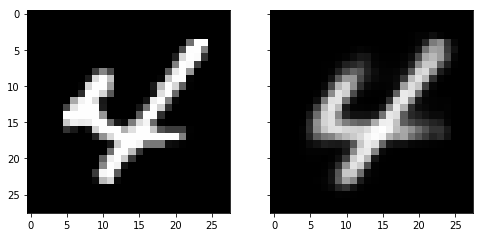

14200 27.921316 17.608276 10.31304


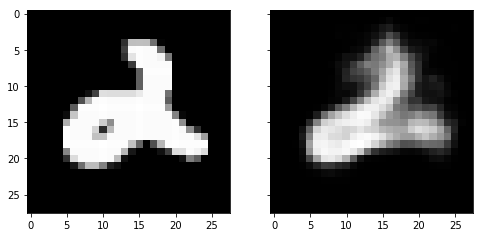

14400 27.655352 17.500273 10.155081


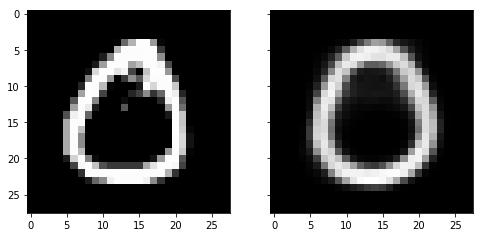

14600 29.15979 18.7755 10.384292


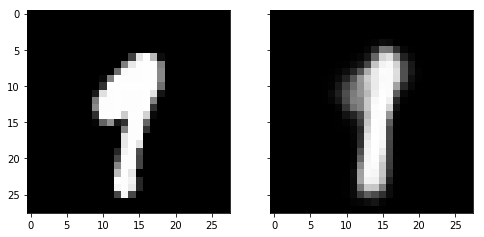

14800 27.930157 17.8171 10.113053


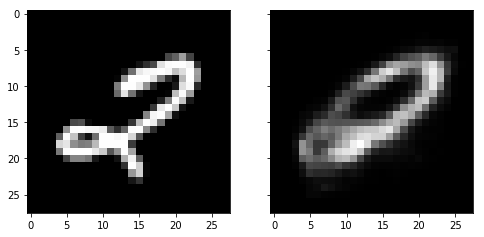

15000 25.89355 15.517646 10.375904


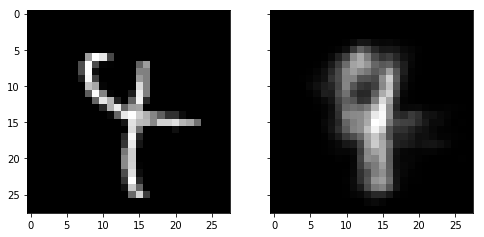

15200 28.56924 17.953981 10.615259


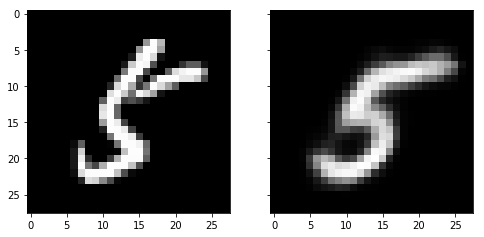

15400 29.403023 18.533928 10.869095


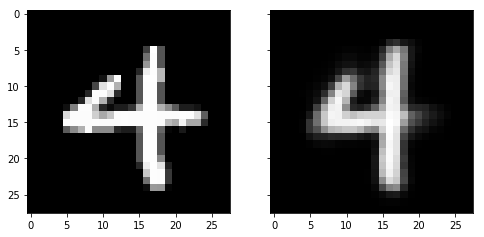

15600 28.175 17.12248 11.052518


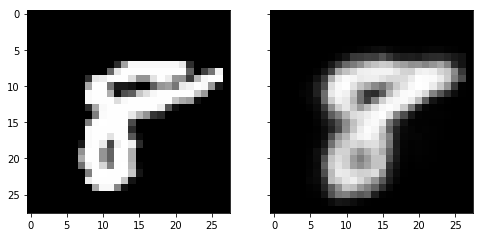

15800 28.684814 17.782478 10.902338


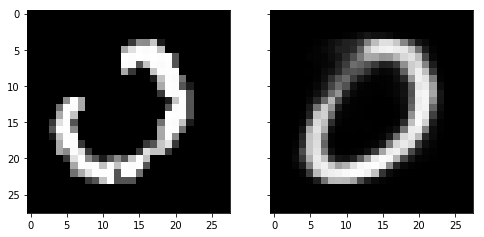

16000 27.732616 17.130379 10.602239


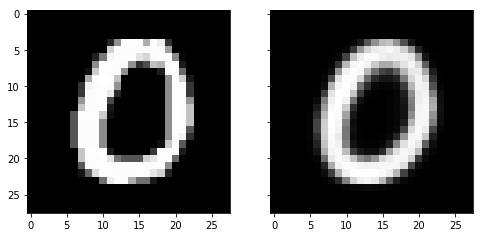

16200 27.15588 16.512878 10.643001


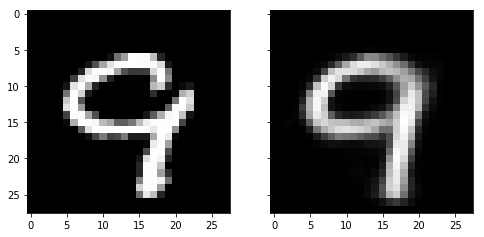

16400 27.474445 16.792992 10.681455


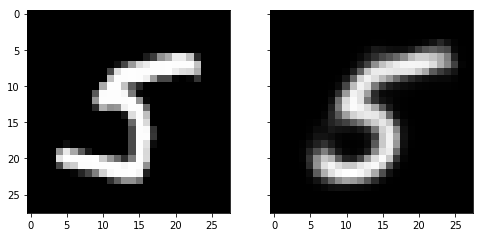

16600 28.623882 18.144257 10.479624


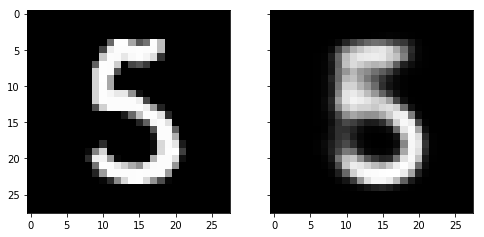

16800 27.490185 16.647299 10.842885


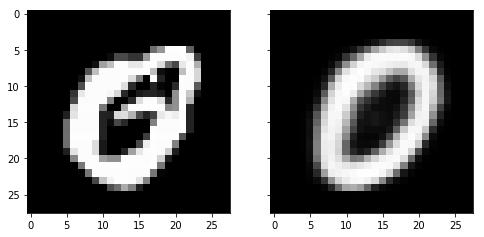

17000 27.44187 16.472273 10.969598


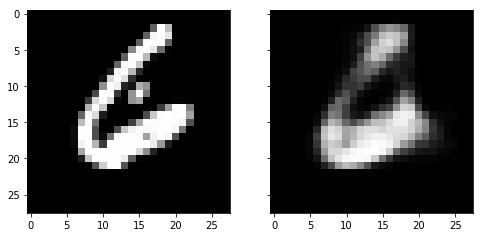

17200 27.828384 16.936432 10.89195


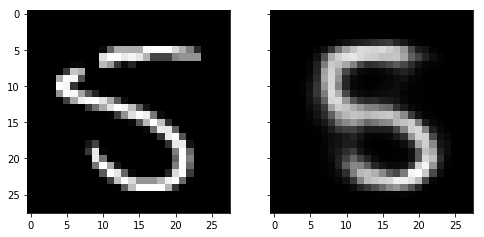

17400 28.533321 18.161854 10.371469


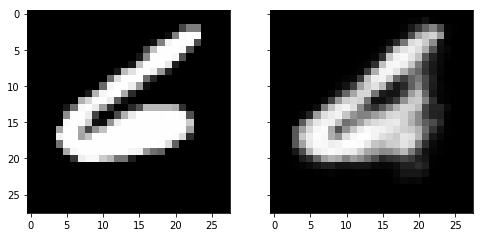

17600 28.99939 18.307922 10.691468


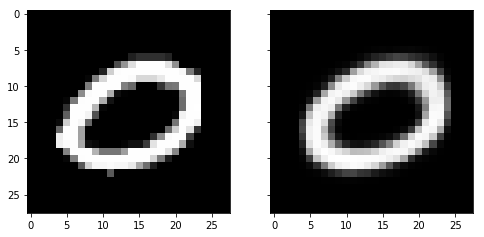

17800 27.347467 15.763886 11.58358


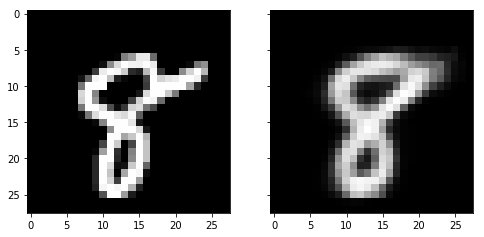

18000 28.004425 17.910433 10.09399


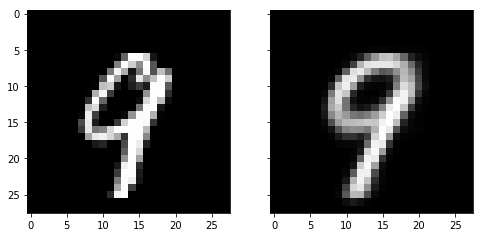

18200 29.059418 18.437672 10.621747


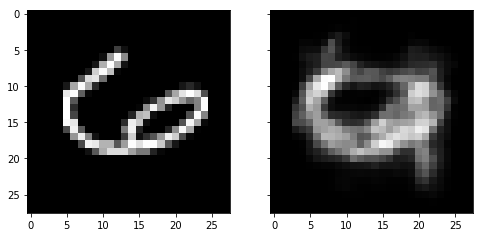

18400 28.847046 18.525818 10.321226


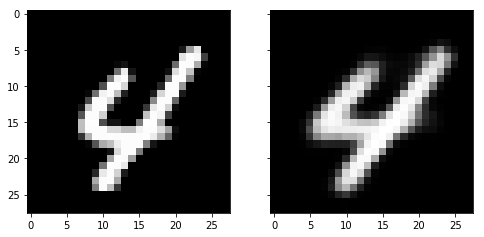

18600 27.504026 16.589525 10.914499


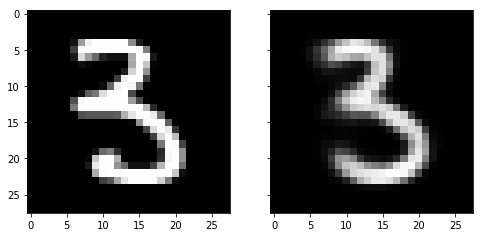

18800 28.81416 18.475613 10.338547


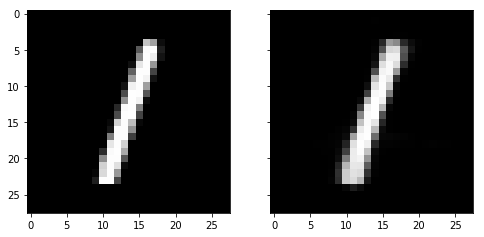

19000 26.61103 15.88655 10.72448


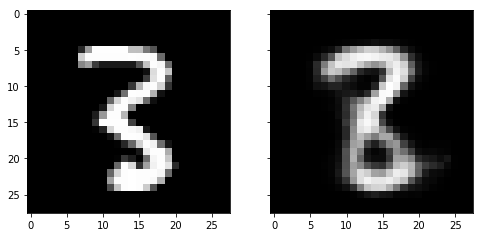

19200 28.242474 17.467056 10.775418


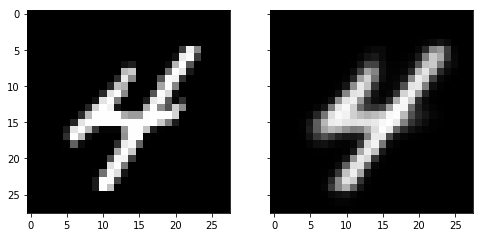

19400 28.967363 18.389847 10.577517


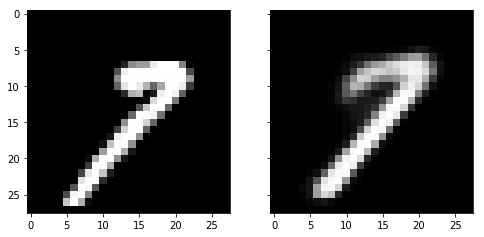

19600 27.870975 16.98826 10.882713


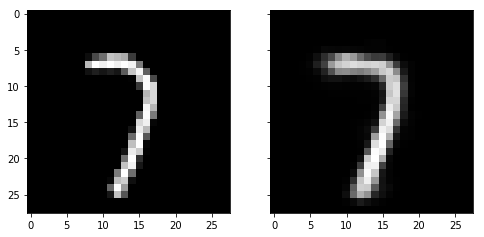

19800 26.541773 15.458064 11.08371


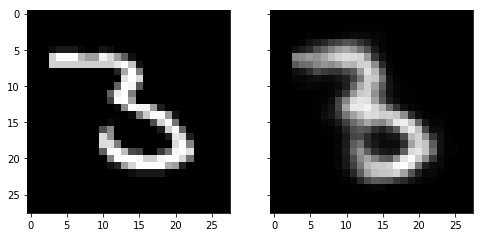

20000 26.940342 16.541788 10.398554


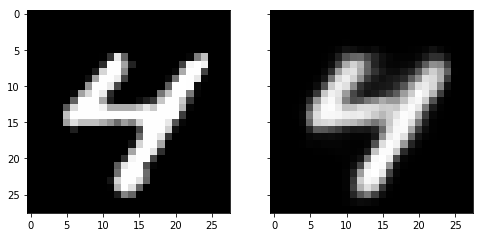

20200 26.951996 16.029264 10.922733


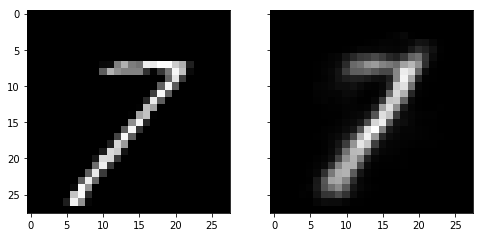

20400 25.5367 14.787464 10.749235


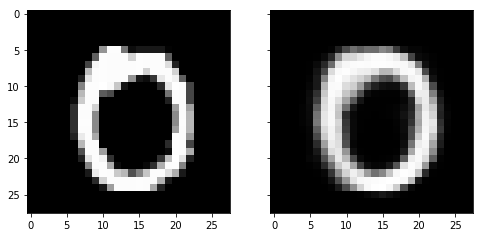

20600 27.851933 17.001003 10.85093


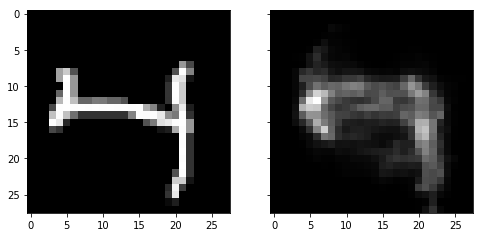

20800 29.141985 18.063938 11.078045


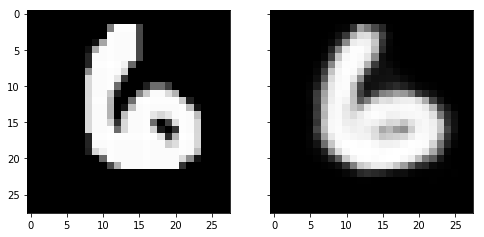

21000 26.26026 15.562046 10.698214


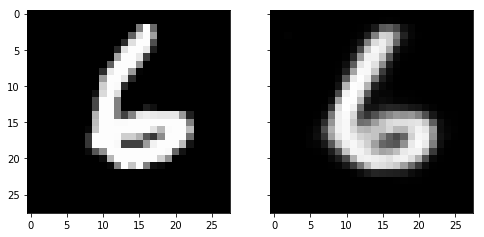

21200 26.977825 16.164764 10.813062


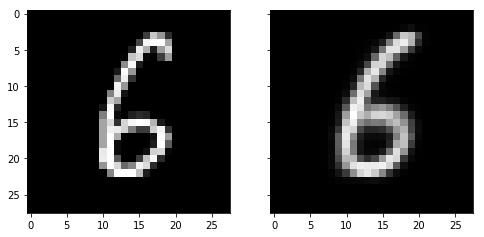

21400 25.593136 15.000103 10.593031


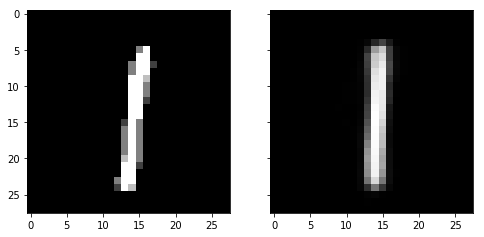

21600 28.013954 17.301155 10.712798


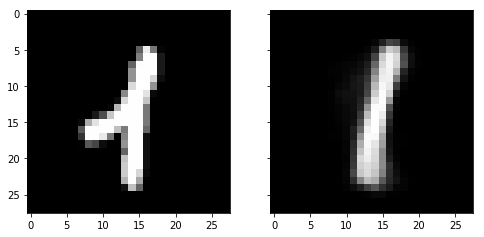

21800 27.064533 16.015411 11.049123


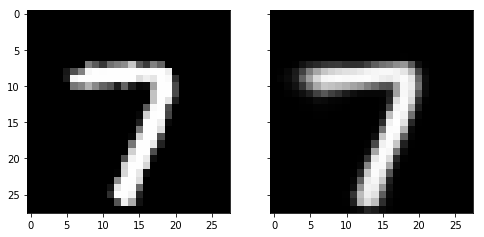

22000 26.664051 16.557793 10.106261


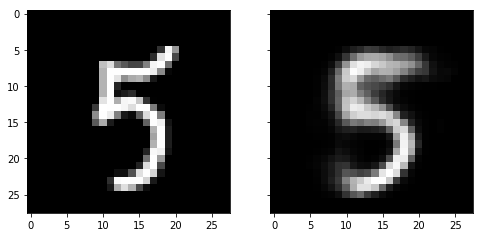

22200 28.123468 16.639067 11.4844


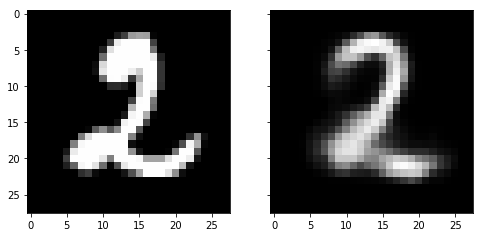

22400 27.162603 16.63015 10.532454


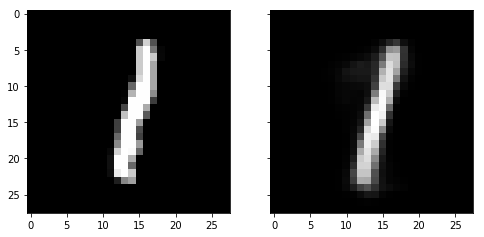

22600 27.468515 16.89997 10.568546


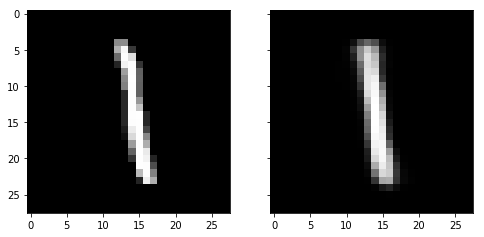

22800 27.041525 16.350685 10.690842


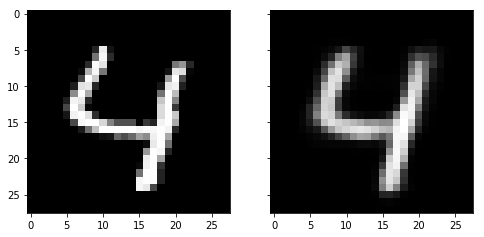

23000 25.532907 15.502688 10.03022


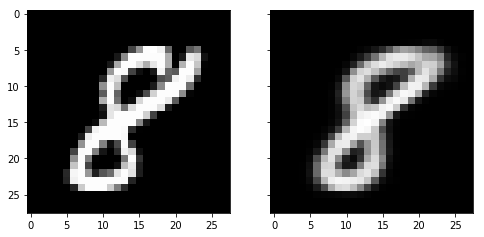

23200 27.740612 17.034283 10.706329


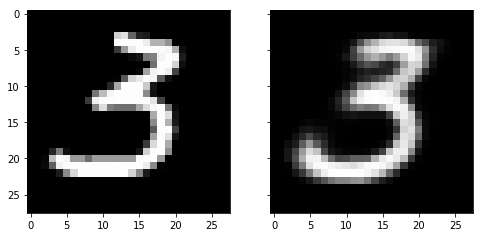

23400 25.53106 14.3041725 11.226885


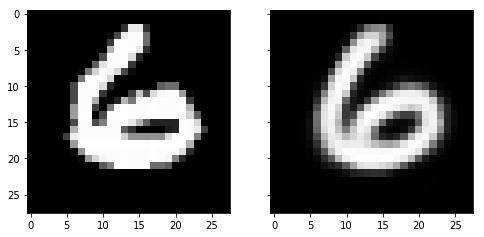

23600 29.110819 17.82697 11.283849


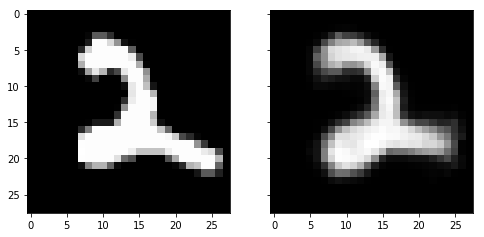

23800 25.608187 15.217493 10.390694


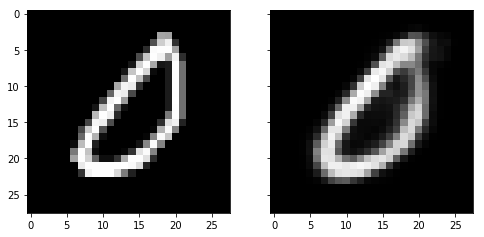

24000 26.933205 15.360923 11.572281


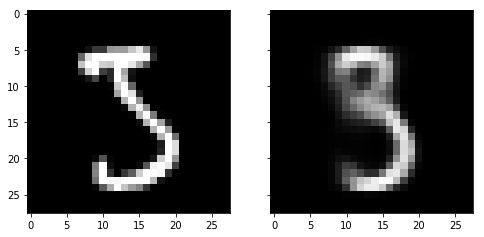

24200 26.54065 16.01439 10.526258


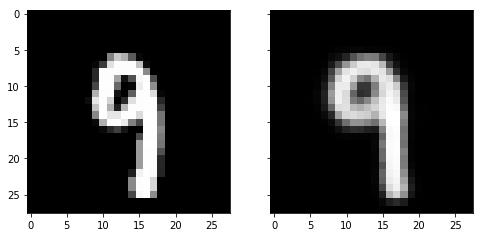

24400 25.569828 15.465696 10.104132


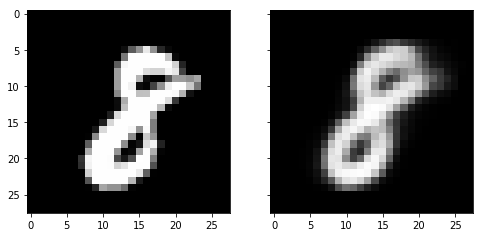

24600 27.629341 16.718113 10.911229


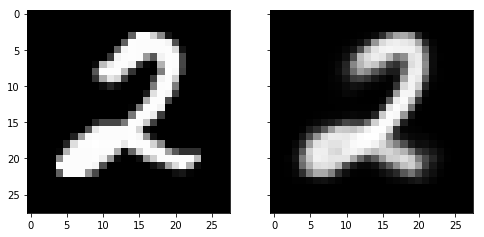

24800 28.52474 17.344154 11.180586


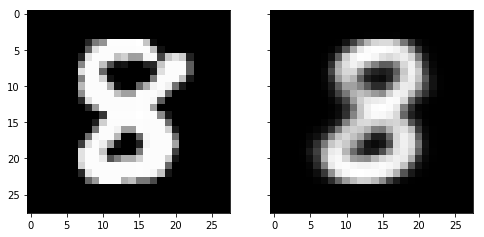

25000 26.656242 16.13102 10.525223


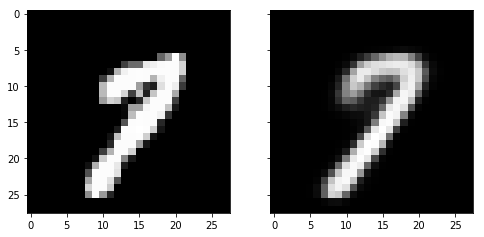

25200 25.786066 15.418972 10.367094


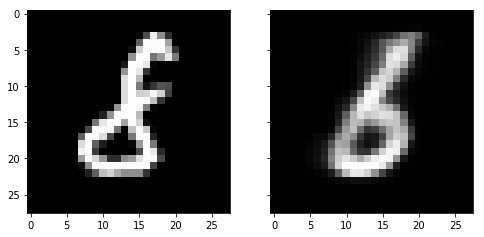

25400 27.153578 16.179462 10.974114


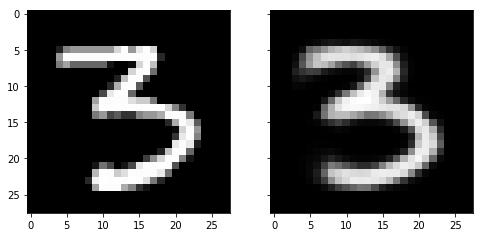

25600 27.286217 16.24574 11.040476


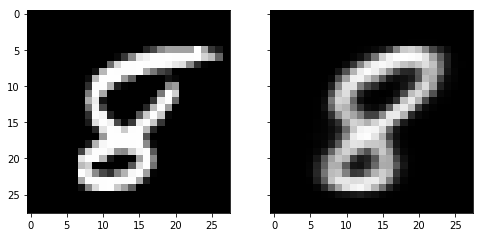

25800 27.209488 16.852785 10.356703


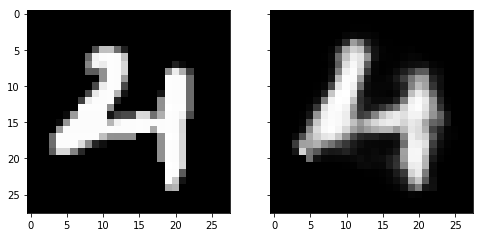

26000 27.185966 16.630949 10.555019


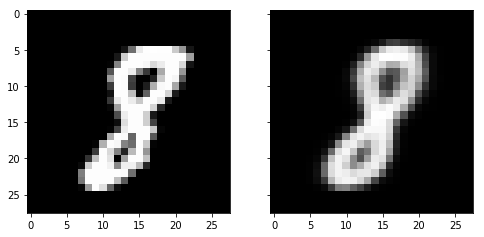

26200 26.853237 16.876366 9.9768715


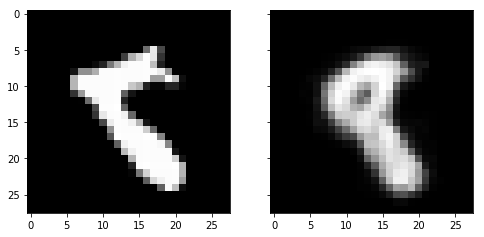

26400 26.867805 16.222721 10.645083


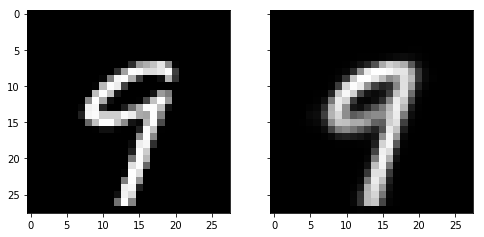

26600 26.561455 15.370707 11.190746


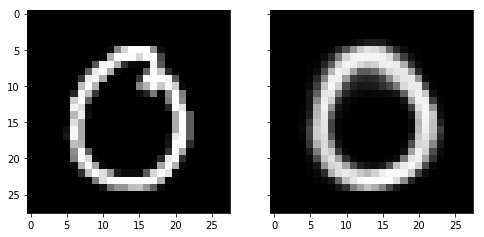

26800 26.883833 15.918932 10.964901


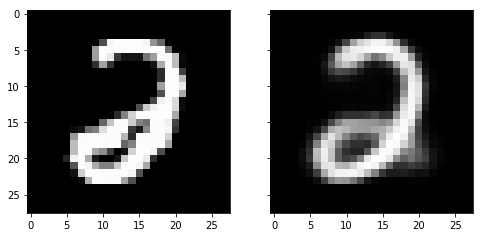

27000 28.242138 17.331577 10.910564


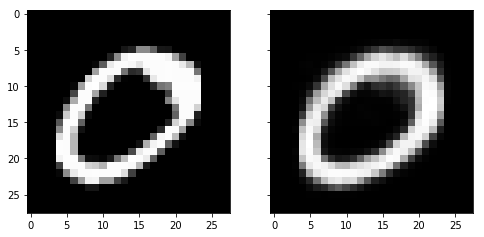

27200 27.290016 16.341934 10.948082


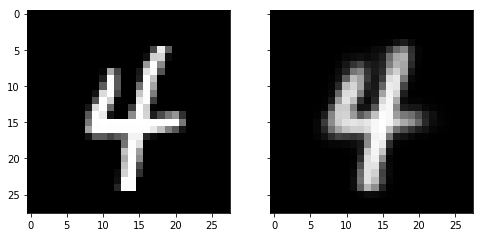

27400 27.36576 15.923628 11.442133


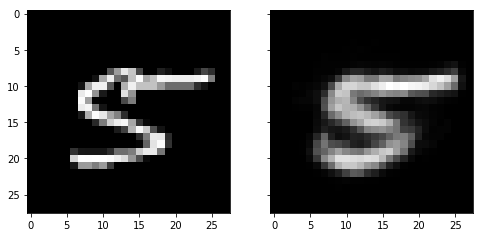

27600 27.598413 16.535515 11.0629


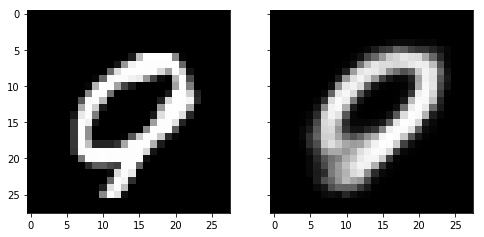

27800 25.59289 15.134063 10.458826


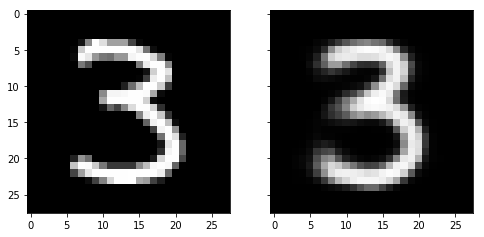

28000 25.765142 14.665791 11.099352


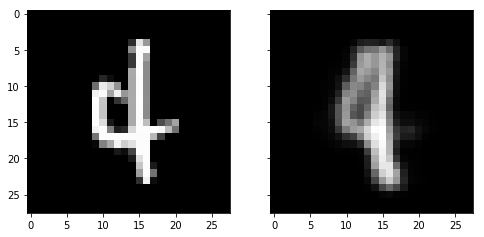

28200 27.575912 16.661772 10.91414


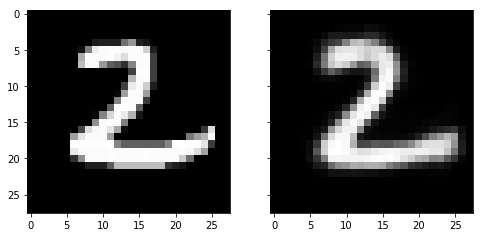

28400 28.22628 17.60381 10.622471


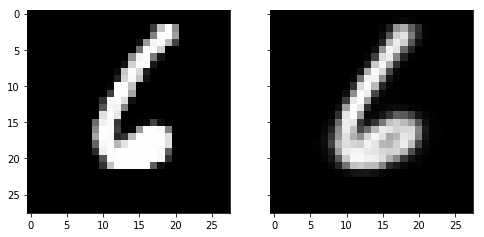

28600 27.149256 16.449245 10.700008


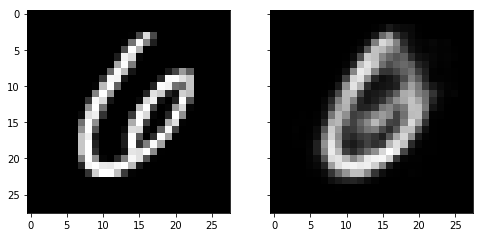

28800 26.72304 15.98424 10.7388


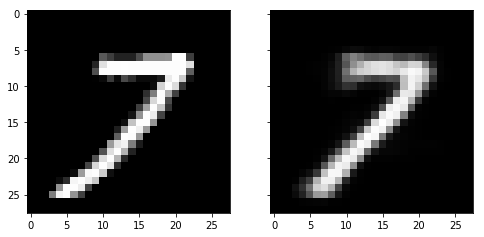

29000 26.262604 15.414007 10.848598


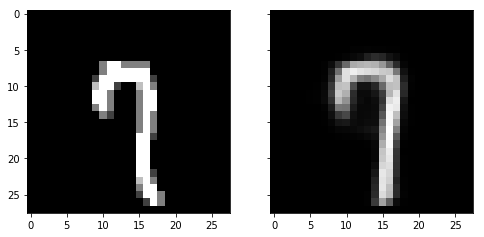

29200 27.380302 16.54034 10.839962


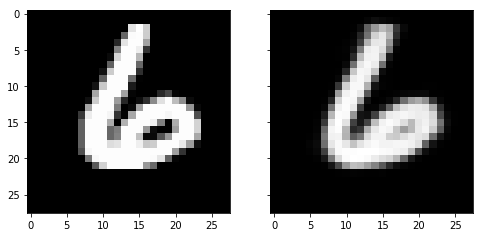

29400 26.570887 15.573009 10.997877


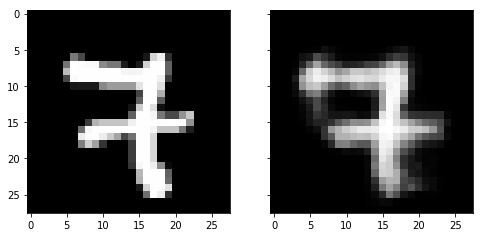

29600 25.94686 14.898413 11.048447


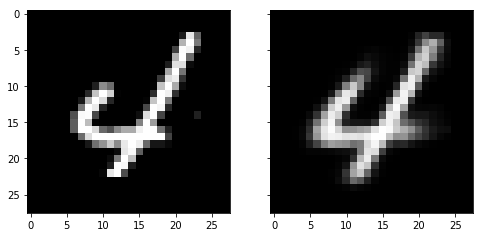

29800 26.815758 15.843102 10.972656


In [11]:
vloss = []
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    l, _ = sess.run([loss, optimizer], feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
    vloss.append(l)
    
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        
        fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(8,12))
        
        axes[0].imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        #plt.show()
        axes[1].imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

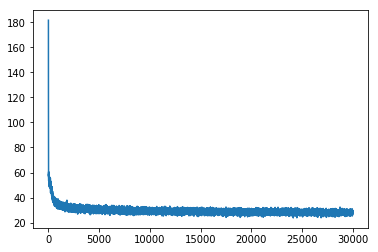

In [12]:
plt.figure()
plt.plot(vloss)

### Generating new data
The most awesome part is that we are now able to create new characters. To this end, we simply sample values from a unit normal distribution and feed them to our decoder. Most of the created characters look just like they've been written by humans.

In [13]:
x1 = np.random.normal(0, 1, n_latent)
print(x1)

[ 1.16114378 -0.8076441  -0.13953766 -0.74217957  0.77082946  0.93267664
  0.31933542  0.60170802]


(array([1.01585347, 0.        , 0.50792674, 0.        , 0.50792674,
        0.50792674, 0.50792674, 1.01585347]),
 array([-0.8076441 , -0.56154561, -0.31544713, -0.06934864,  0.17674984,
         0.42284832,  0.66894681,  0.91504529,  1.16114378]),
 <a list of 8 Patch objects>)

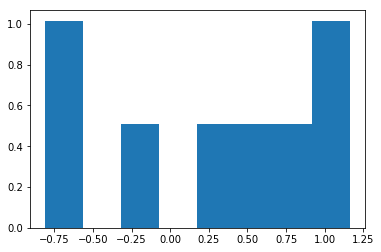

In [14]:
n_bins = n_latent
plt.hist(x1, n_bins, normed=1, histtype='bar')

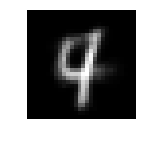

In [15]:
img = sess.run(dec, feed_dict = {sampled: [x1], keep_prob: 1.0})
img = np.reshape(img, [28, 28])
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(img, cmap='gray')

In [16]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
print(np.shape(randoms))

(10, 8)


In [17]:
import os
if not os.path.exists('out'):
    os.makedirs('out')

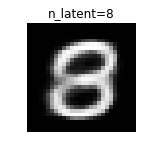

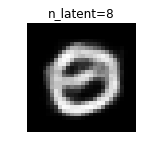

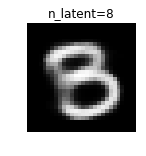

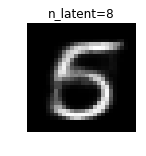

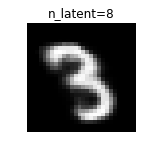

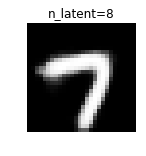

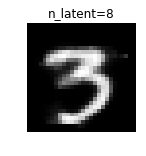

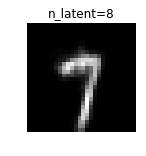

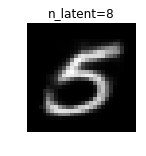

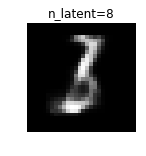

In [18]:
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]
i=0
for img in imgs:
    f1 = plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.title('n_latent={}'.format(n_latent))
    plt.imshow(img, cmap='gray')
    plt.savefig('out/l{}_{}.png'.format(n_latent, i))
    i = i+1

### Just for test

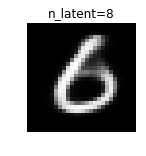

In [19]:
x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, 0.7, -0.5, -2.5]
#x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, -0.7, -0.5, -2.5, 1.2, 1.8, -0.1, 0.7, -0.2, 0.7, -0.5, 0.0]
img = sess.run(dec, feed_dict = {sampled:[x2], keep_prob: 1.0})
img = np.reshape(img, [28, 28])
plt.figure(figsize=(2,2))
plt.axis('off')
plt.title('n_latent={}'.format(n_latent))
plt.imshow(img, cmap='gray')

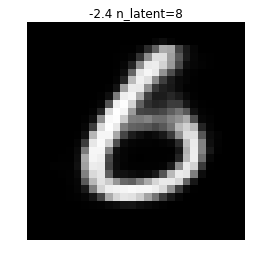

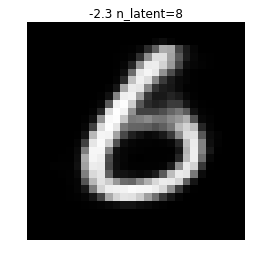

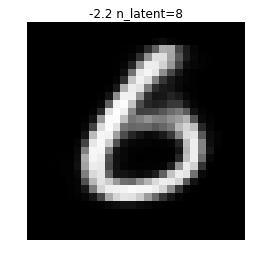

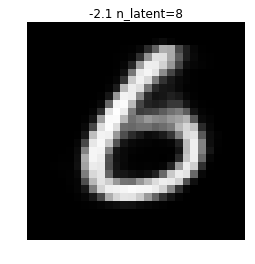

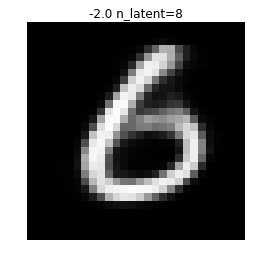

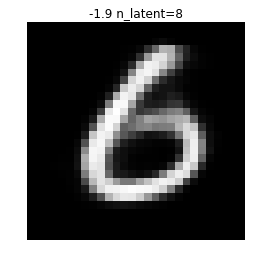

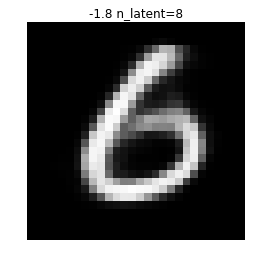

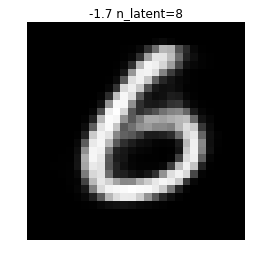

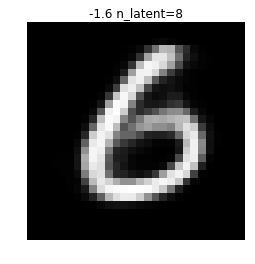

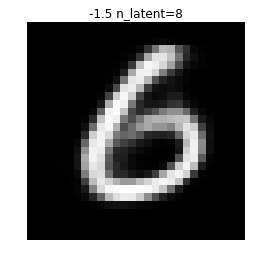

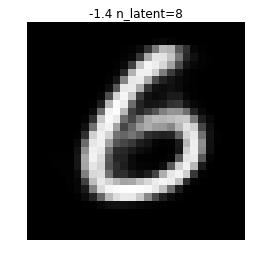

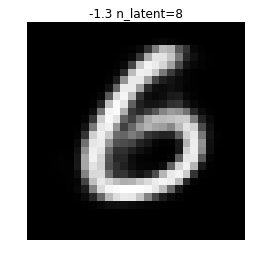

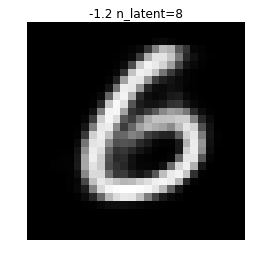

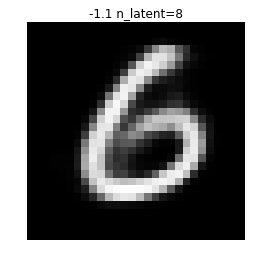

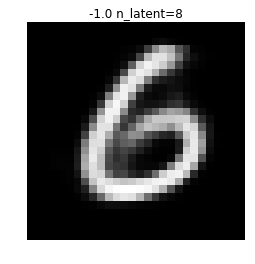

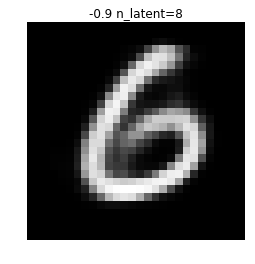

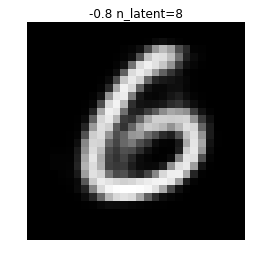

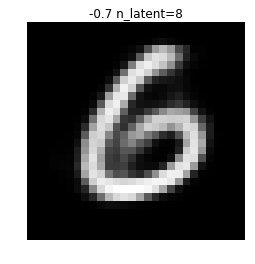

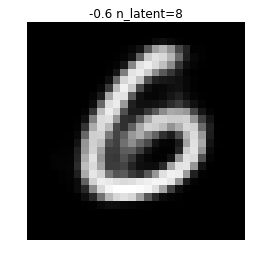

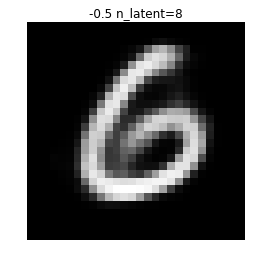

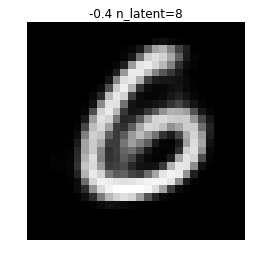

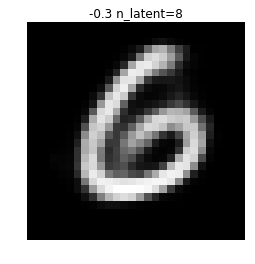

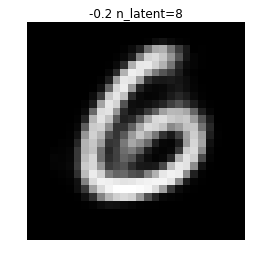

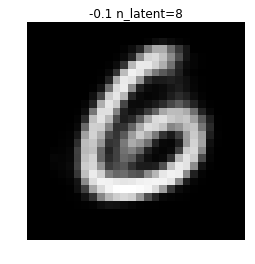

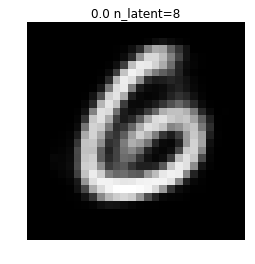

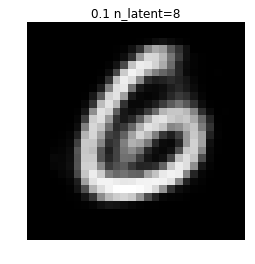

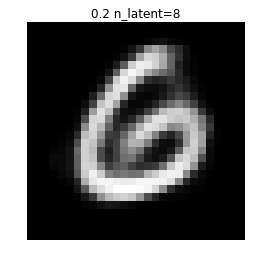

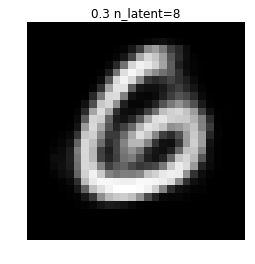

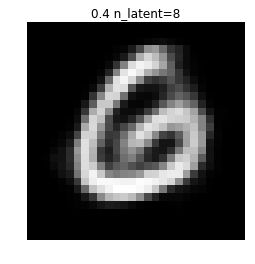

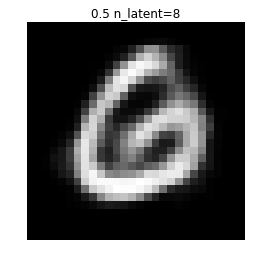

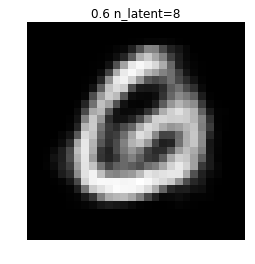

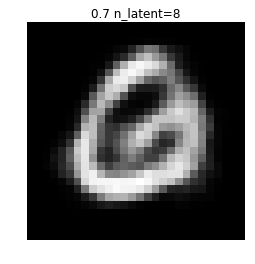

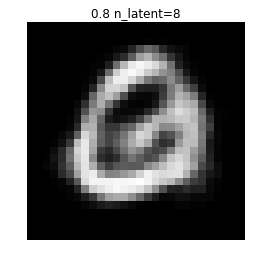

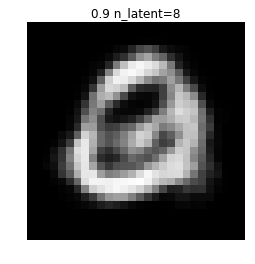

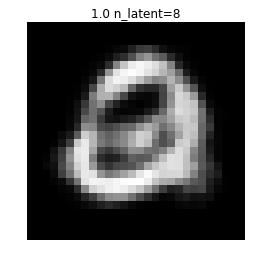

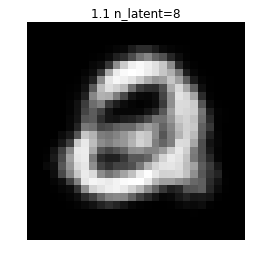

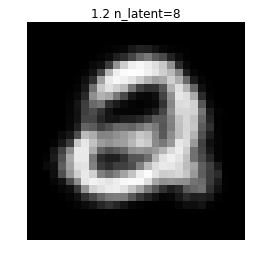

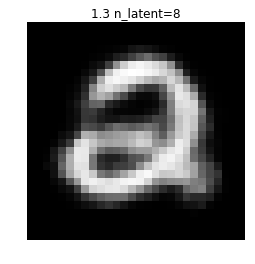

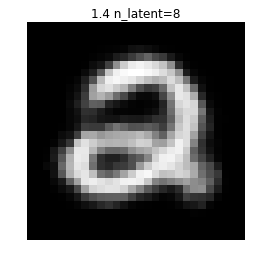

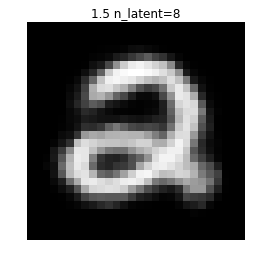

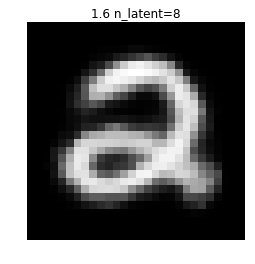

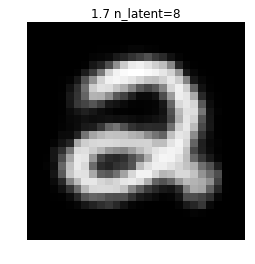

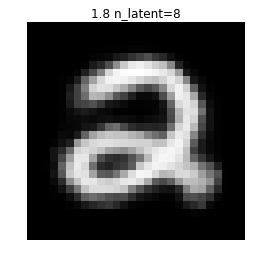

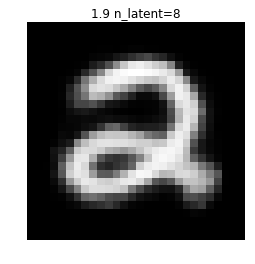

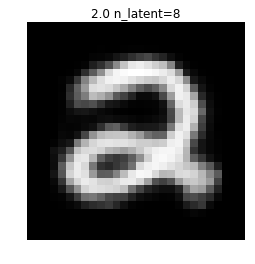

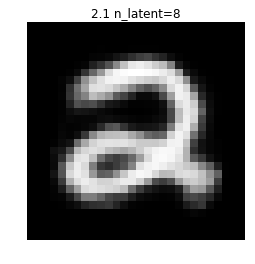

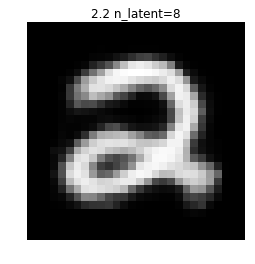

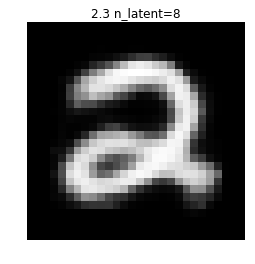

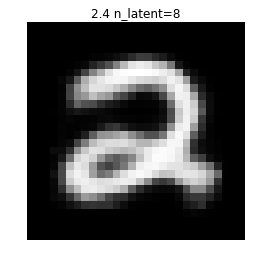

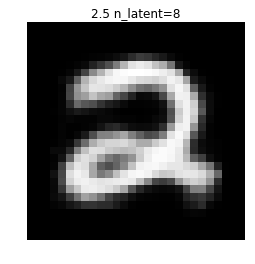

In [20]:
x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, 0.7, -0.5, -2.5]
#x2 = [-1.0, 1.0, 0.1, 0.3, -0.2, -0.7, -0.5, -2.5, 1.2, 1.8, -0.1, 0.7, -0.2, 0.7, -0.5, 0.0]
for i in range(50):
    x2[7] = x2[7]+0.1
    img = sess.run(dec, feed_dict = {sampled:[x2], keep_prob: 1.0})
    img = np.reshape(img, [28, 28])
    plt.figure()
    plt.axis('off')
    plt.title('{} n_latent={}'.format(round(x2[7], 2), n_latent))
    plt.imshow(img, cmap='gray')
    plt.savefig('out/test_l{}_{}.png'.format(n_latent, i))

### References
* https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
* https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/VAE.ipynb